In [1]:
# Import standardowych bibliotek
import pandas as pd
import numpy as np
import itertools
from datetime import datetime as dt

# Import bibliotek do wizualizacji
import matplotlib.pyplot as plt
import seaborn as sns

# Import bibliotek do obróbki danych i modelowania
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# Aktywacja wyświetlania wykresów w notebooku
%matplotlib inline


In [2]:
dataset = pd.read_csv(r'C:\Magisterka\Predicting-the-results-of-Premier-League-matches\TEST\final_dataset_2.csv')

In [3]:
# Remove few column
dataset2 = dataset.copy().drop(columns =['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'HTGS', 'ATGS', 'HTGC', 'ATGC',
       'HM4', 'HM5','AM4', 'AM5', 'MW', 'HTFormPtsStr',
       'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
       'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3',
       'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
       'DiffPts'] )

In [4]:
X_all = dataset2.drop(['FTR'], axis=1)  # Użycie nazwanego argumentu axis
y_all = dataset2['FTR']

# Wybór kolumn do standaryzacji
cols = ['HTGD', 'ATGD', 'HTP', 'ATP']
X_all[cols] = scale(X_all[cols])  # Standaryzacja wybranych kolumn


In [5]:
def preprocess_features(X):
    ''' Preprocesses the football data and converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index=X.index)

    # Investigate each feature column for the data
    for col, col_data in X.items():  # Użycie items() zamiast iteritems()

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Przetwarzanie danych
X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))


Processed feature columns (30 total features):
['Unnamed: 0', 'HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts']


In [6]:
# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.3,
                                                    random_state = 2,
                                                    stratify = y_all)

In [7]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [8]:
Y_pred = classifier.predict(X_test)

In [9]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)  # Zakodowanie rzeczywistych etykiet
y_pred_encoded = le.transform(Y_pred)  # Zakodowanie przewidywanych etykiet

In [10]:
cm = confusion_matrix(y_test, Y_pred)

In [11]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           H       0.62      0.51      0.56       613
          NH       0.65      0.74      0.69       755

    accuracy                           0.64      1368
   macro avg       0.63      0.63      0.63      1368
weighted avg       0.64      0.64      0.63      1368



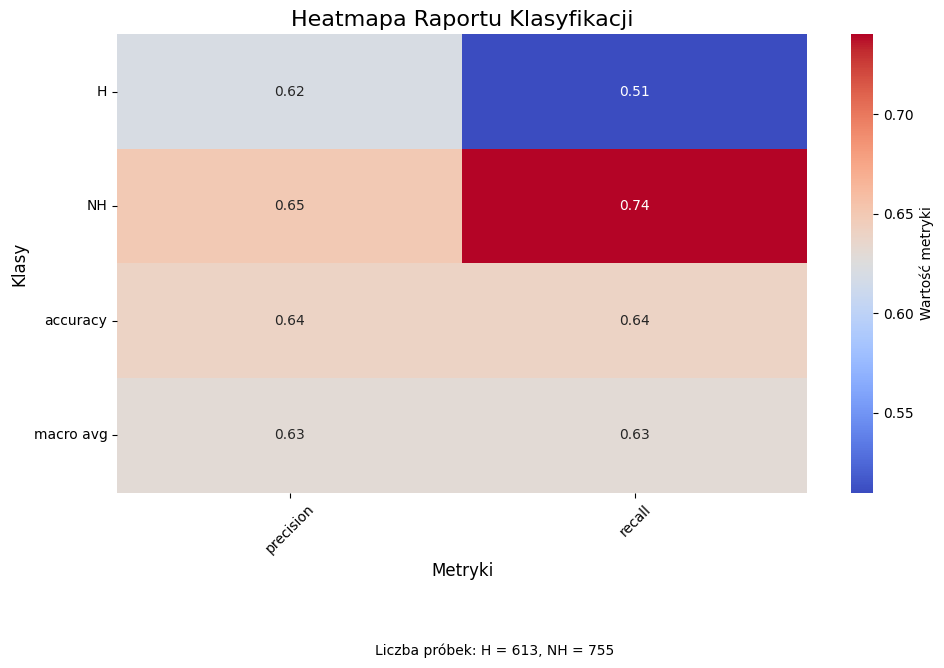

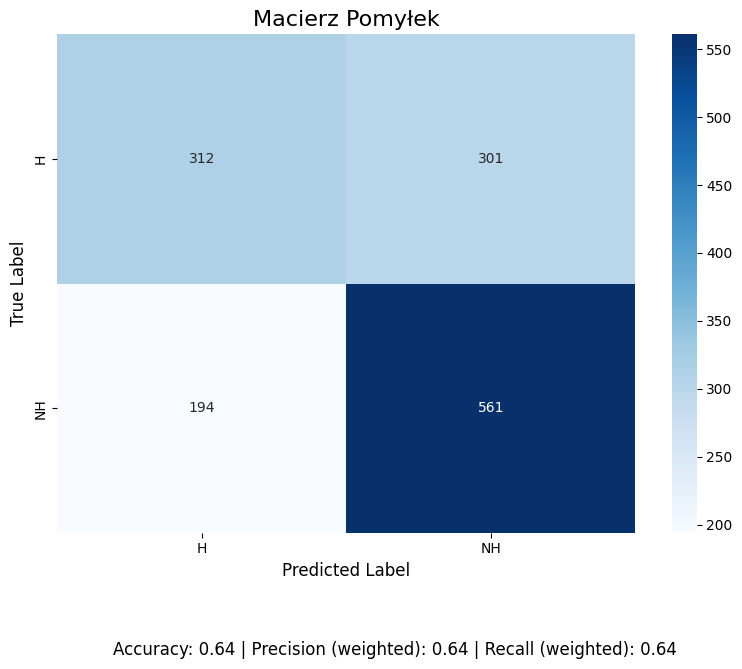

In [12]:
def plot_classification_report(y_test, y_pred):
    # Generowanie raportu klasyfikacji
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()

    # Zaokrąglenie wartości
    metrics_df = metrics_df.round(2)
    support_values = metrics_df['support'].dropna().astype(int)  # Wyciągnięcie support
    metrics_df.drop(columns=['support'], inplace=True)  # Usunięcie support z heatmapy

    # Wizualizacja heatmapy (bez support)
    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt='.2f', cbar_kws={'label': 'Wartość metryki'})
    plt.title("Heatmapa Raportu Klasyfikacji", fontsize=16)
    plt.xlabel("Metryki", fontsize=12)
    plt.ylabel("Klasy", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Dodanie tabeli support poniżej wykresu
    plt.figtext(0.5, -0.1, f"Liczba próbek: H = {support_values['H']}, NH = {support_values['NH']}", 
                wrap=True, horizontalalignment='center', fontsize=10, color='black')
    plt.show()



def plot_confusion_matrix(y_test, y_pred, labels):
    # Tworzenie macierzy pomyłek
    cm = confusion_matrix(y_test, y_pred)
    
    # Wizualizacja macierzy
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Macierz Pomyłek", fontsize=16)

    # Obliczanie metryk
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Średnia ważona
    recall = recall_score(y_test, y_pred, average='weighted')  # Średnia ważona
    
    # Dodanie informacji o metrykach i liczbie próbek poniżej wykresu
    plt.figtext(0.5, -0.1, f"Accuracy: {accuracy:.2f} | Precision (weighted): {precision:.2f} | Recall (weighted): {recall:.2f}", 
                wrap=True, horizontalalignment='center', fontsize=12)
    
    # Wyświetlanie wykresu
    plt.tight_layout()
    plt.show()

# Wywołanie wizualizacji
labels = le.classes_  # Oryginalne etykiety
plot_classification_report(y_test, Y_pred)
plot_confusion_matrix(y_test_encoded, y_pred_encoded, labels)

In [1]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

print("Model zapisany jako 'model.pkl'")

NameError: name 'classifier' is not defined